<a href="https://colab.research.google.com/github/xtliao/PyTorchProjects/blob/main/nn_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.&nbsp;Check PyTorch version and setup device

In [164]:
import torch
print(f"PyTorch versiion: {torch.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch versiion: 2.3.1+cu121
Device: cuda


#2.&nbsp;Prep dataset and dataloader

## 2.1. Download train and test datasets

In [165]:
import torchvision
from torchvision import datasets, transforms

train_dataset = datasets.FashionMNIST(root="data",
                                      train=True,
                                      download=True,
                                      transform=transforms.ToTensor(),
                                      target_transform=None)
test_dataset = datasets.FashionMNIST(root="data",
                                     train=False,
                                     download=True,
                                     transform=transforms.ToTensor(),
                                     target_transform=None)

train_dataset, test_dataset

class_names = train_dataset.classes
print(f"The following {len(class_names)} classes are in the train dataset:\n")
print(class_names)


The following 10 classes are in the train dataset:

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


2.2. Visualize some random data from the dataset

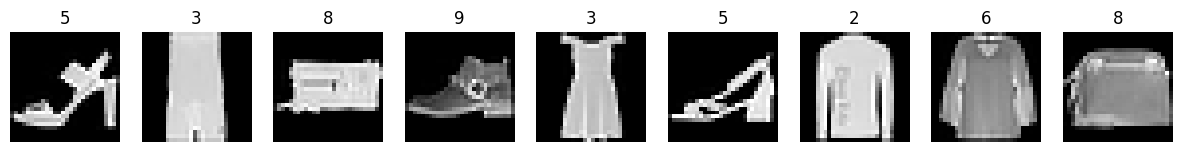

In [166]:
import random
import matplotlib.pyplot as plt

NUM_SAMPLES = 9

random_sample_ids = random.sample(range(len(train_dataset)), k=NUM_SAMPLES)
fig, axs = plt.subplots(1, NUM_SAMPLES, figsize=(15,7))

for i, id in enumerate(random_sample_ids):
  input, label = train_dataset[id]
  axs[i].imshow(input.squeeze(), cmap="gray")
  axs[i].axis(False)
  axs[i].set_title(label)


## 2.3. Turn datasets into dataloaders

In [167]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False)
print(f"Length of train dataloader: {len(train_dataset):,} / 32 = {len(train_dataloader):,}\n")
print(f"Length of test  dataloader: {len(test_dataloader):,} / 32 = {len(test_dataloader):,}\n")

first_dataloader = next(iter(train_dataloader))
print(f"Shape of inputs: {first_dataloader[0].shape}")
print(f"Shape of labels: {first_dataloader[1].shape}")


Length of train dataloader: 60,000 / 32 = 1,875

Length of test  dataloader: 313 / 32 = 313

Shape of inputs: torch.Size([32, 1, 28, 28])
Shape of labels: torch.Size([32])


#3.&nbsp; Define train and test loop functions

## 3.1. train_loop() function

In [168]:
import torch.nn as nn

def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               metric_fn,
               device: torch.device = device):
  model.to(device)
  model.train()

  train_loss, train_metric = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    logits = model(X)
    loss = loss_fn(logits, y)

    preds = logits.softmax(dim=1).argmax(dim=1)
    metric = metric_fn(preds, y)

    train_loss += loss.item()
    train_metric += metric.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_metric /= len(dataloader)

  return train_loss, train_metric

## 3.2. test_loop() function

In [169]:
def test_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metric_fn,
              device: torch.device = device):

  model.to(device)
  model.eval()

  test_loss, test_metric = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      logits = model(X)
      loss = loss_fn(logits, y)

      preds = logits.softmax(dim=1).argmax(dim=1)
      metric = metric_fn(preds, y)

      test_loss += loss.item()
      test_metric += metric.item()

    test_loss /= len(dataloader)
    test_metric /= len(dataloader)

  return test_loss, test_metric

#4.&nbsp; Define train model function

In [170]:
from tqdm.auto import tqdm
from timeit import default_timer

def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                metric_fn,
                device: torch.device = device,
                epochs: int = 3):

  start = default_timer()

  train_losses, train_metrics = [], []
  test_losses, test_metrics = [], []

  for epoch in tqdm(range(epochs), desc="Training model..."):
    train_loss, train_metric = train_loop(model, train_dataloader, optimizer, loss_fn, metric_fn, device)
    test_loss, test_metric = test_loop(model, test_dataloader, loss_fn, metric_fn, device)

    print(f"Epoch: {epoch:3n} | Train loss: {train_loss:.5f}, train metric: {train_metric:.2%} | Test loss: {test_loss:.5f}, test metric: {test_metric:.2%}")

    # save them for later curves plotting
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)

  train_time = default_timer() - start
  print(f"Total train time: {train_time:.2f} seconds")

  return train_losses, train_metrics, test_losses, test_metrics

#5.&nbsp;Define new model

## 5.1. Copy the model from CNN Explainer

In [171]:
import torch.nn as nn

class MyFashionMNISTModel(nn.Module):
  def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=out_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classifier(x)
    return x

model_0 = MyFashionMNISTModel(in_shape=1, # 1 means nor color image
                              hidden_units=10,
                              out_shape=len(class_names))
model_0

MyFashionMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 5.2. Test the new model before trainning with the first test dataset

Shape of X: torch.Size([1, 28, 28])
Prediction label: tensor([4]), class name is: Coat


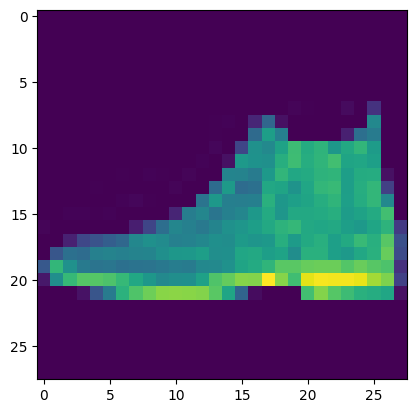

In [172]:
X, y = test_dataset[0]
print(f"Shape of X: {X.shape}")
pred = model_0(X.unsqueeze(0)).softmax(dim=1).argmax(dim=1)
print(f"Prediction label: {pred}, class name is: {class_names[pred.item()]}")
plt.imshow(X.squeeze(0))


#6.&nbsp;Define loss, metric and optimizer functions

## 6.1. Install torchmetrics

In [173]:
try:
  import torcheval
except:
  !pip install torcheval --quiet
  import torcheval

print(f"torcheval version: {torcheval.__version__}")

torcheval version: 0.0.7


In [174]:
try:
  import torchmetrics
except:
  !pip install torchmetrics --quiet
  import torchmetrics

print(f"torchmetrics version: {torchmetrics.__version__}")

torchmetrics version: 1.4.1


## 6.2. Define functions

In [175]:
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
metric_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=len(class_names)).to(device)

#7.&nbsp;Train new model

## 7.1. Train new model

In [176]:
NUM_EPOCHS =5

train_losses, train_metrics, test_losses, test_metrics = train_model(model=model_0,
                                                                    train_dataloader=train_dataloader,
                                                                    test_dataloader=test_dataloader,
                                                                    optimizer=optimizer,
                                                                    loss_fn=loss_fn,
                                                                    metric_fn=metric_fn,
                                                                    device=device,
                                                                    epochs=NUM_EPOCHS)

Training model...:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0 | Train loss: 0.49180, train metric: 81.26% | Test loss: 0.42015, test metric: 84.27%
Epoch:   1 | Train loss: 0.38285, train metric: 84.94% | Test loss: 0.44703, test metric: 83.19%
Epoch:   2 | Train loss: 0.37108, train metric: 85.19% | Test loss: 0.38453, test metric: 84.87%
Epoch:   3 | Train loss: 0.36009, train metric: 85.70% | Test loss: 0.37712, test metric: 85.16%
Epoch:   4 | Train loss: 0.35903, train metric: 86.02% | Test loss: 0.40483, test metric: 84.18%
Total train time: 77.71 seconds


## 7.2. Plot the train and test loss/metric curves


  train_losses:[0.4917999798576037, 0.3828469529191653, 0.3710781905770302, 0.3600899955133597, 0.3590293717722098], 

  test_losses:[0.4201544990507178, 0.44703069307838383, 0.38453297916883095, 0.37711905167934995, 0.4048295142932441], 
 
  train_metrics:[0.8126337851603825, 0.8494132471084594, 0.851888888835907, 0.8570473987897237, 0.8602019472122192], 
 
  test_metrics:[0.8427115760672207, 0.831911624810947, 0.8486966326975593, 0.8515639697400906, 0.8418244026339473], 

  


Text(0, 0.5, 'Accuracy')

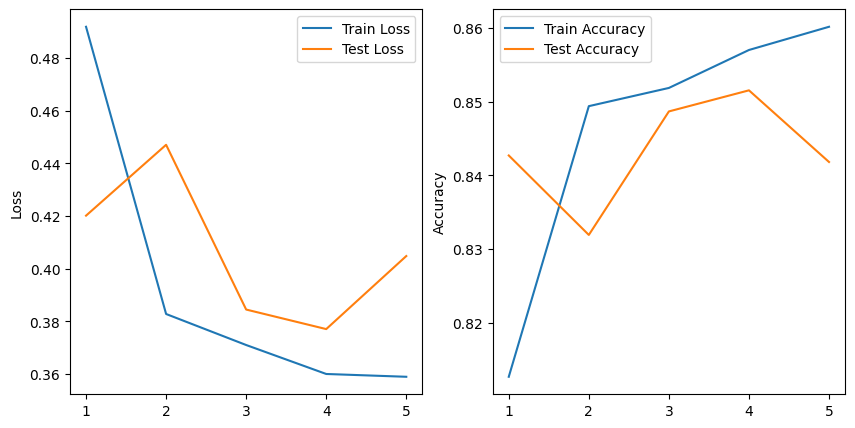

In [177]:
print(f'''
  train_losses:{train_losses}, \n
  test_losses:{test_losses}, \n
  train_metrics:{train_metrics}, \n
  test_metrics:{test_metrics}, \n
  ''')

fig, axs = plt.subplots(1, 2, figsize =(10,5))

# Loss
axs[0].plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
axs[0].plot(range(1, NUM_EPOCHS+1), test_losses, label="Test Loss")
axs[0].legend()
axs[0].set_ylabel("Loss")

# Metric
axs[1].plot(range(1, NUM_EPOCHS+1), train_metrics, label="Train Accuracy")
axs[1].plot(range(1, NUM_EPOCHS+1), test_metrics, label="Test Accuracy")
axs[1].legend()
axs[1].set_ylabel("Accuracy")


#8.&nbsp;Define model evaluation function

## 8.1. Define the eval_model() function

In [178]:
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               metric_fn,
               device: torch.device = device,
               model_name: str = None):
  model.to(device)
  model.eval()

  eval_loss, eval_metric = 0, 0
  eval_results = {"model_name": str,
                  "eval_loss": float,
                  "eval_metric": float}

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      logits = model(X)
      loss = loss_fn(logits, y)

      preds = logits.softmax(dim=1).argmax(dim=1)
      metric = metric_fn(preds, y)

      eval_loss += loss.item()
      eval_metric += metric.item()

    eval_loss /= len(dataloader)
    eval_metric /= len(dataloader)
  if model_name is None:
    model_name = model.__class__.__name__
  eval_results["model_name"] = model_name
  eval_results["eval_loss"] = eval_loss
  eval_results["eval_metric"] = eval_metric

  return eval_results

## 8.2. Evaluate the previous trained model

In [179]:
eval_results_model_0 = eval_model(model=model_0,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  metric_fn=metric_fn,
                                  device = device,
                                  model_name="model_0")
eval_results_model_0

{'model_name': 'model_0',
 'eval_loss': 0.4048295142932441,
 'eval_metric': 0.8418244026339473}

#9.&nbsp;Define make prediction function

## 9.1. Define make_predictions() function

In [180]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
  model.to(device)
  model.eval()

  preds = []
  with torch.inference_mode():
    for sample in data:
      X = torch.unsqueeze(sample, dim=0).to(device)
      pred = model(X).softmax(dim=1).argmax(dim=1)
      preds.append(pred)

  return torch.cat(preds)

## 9.2. Make some random predctions and visualize them

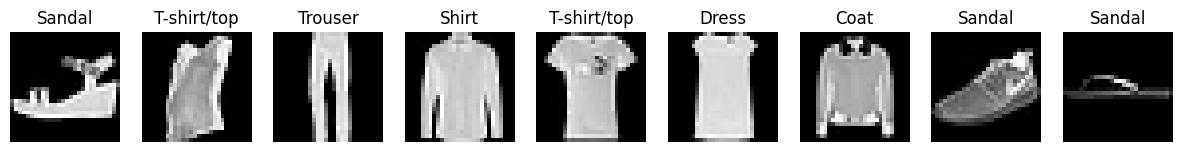

In [181]:
# data = [test_dataset[0][0], test_dataset[1][0]]
data = [test_dataset[i][0] for i in (random.sample(range(0, len(test_dataset)), k=9))]
preds = make_predictions(model_0, data)
fig, axs = plt.subplots(1, len(data), figsize=(15,7))
for i in range(len(data)):
  axs[i].imshow(data[i].squeeze(0), cmap="gray")
  axs[i].axis(False)
  axs[i].set_title(class_names[preds[i]])

#10.&nbsp;Plot confusion matrix

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

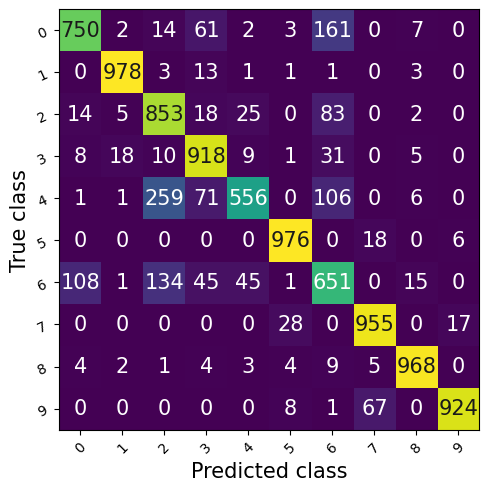

In [182]:
model_0.to(device)
model_0.eval()

preds = []
labels = []
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model_0(X).softmax(dim=1).argmax(dim=1)
    preds.append(pred.detach())
    labels.append(y.detach())

preds = torch.cat(preds).to(device)
labels = torch.cat(labels).to(device)
conf_mat = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=len(class_names)).to(device)
conf_mat(preds=preds, target=labels)
conf_mat.plot()

#11.&nbsp;Save and reload model

## 11.1. Save model state_dict

In [183]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "PyTorch_nn_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
print(f"run !ls -l models")
!ls -l models

Saving model to: models/PyTorch_nn_FashionMNIST.pth
run !ls -l models
total 36
-rw-r--r-- 1 root root 35032 Aug 23 16:00 PyTorch_nn_FashionMNIST.pth


## 11.2. Load the saved model state_dict to a new model

In [184]:
model_1 = MyFashionMNISTModel(in_shape=1,
                              hidden_units=10,
                              out_shape=len(class_names))
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_1

MyFashionMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 11.3. Eval the new model

In [185]:
eval_results_model_1 = eval_model(model=model_1,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 metric_fn=metric_fn,
                                 device=device,
                                 model_name="model_1")
print(f"eval_results_model_1: {eval_results_model_1}")
print(f"eval_results_model_0: {eval_results_model_0}")


eval_results_model_1: {'model_name': 'model_1', 'eval_loss': 0.4048295142932441, 'eval_metric': 0.8418244026339473}
eval_results_model_0: {'model_name': 'model_0', 'eval_loss': 0.4048295142932441, 'eval_metric': 0.8418244026339473}
